# Overlapping phytochemicals (natural products in plants) with approved-drugs (Newman dataset)

### Import modules

In [23]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from rdkit import RDLogger  
from rdkit.Chem.inchi import MolToInchi, InchiToInchiKey
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

import matplotlib as mpl
from matplotlib_venn import venn3
from matplotlib import pyplot as plt

In [2]:
%config Application.log_level='INFO'
import logging
logging.getLogger('s3fs').setLevel(logging.INFO)
logging.getLogger('botocore').setLevel(logging.INFO)
logging.getLogger('fsspec').setLevel(logging.INFO)

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360

In [28]:
%matplotlib inline

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [4]:
RDLogger.DisableLog('rdApp.*')

Load Newman data

In [5]:
natural_products_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_natural_products.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

synthetics_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_synthetics.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

In [6]:
natural_products_df.shape, synthetics_df.shape

((398, 4), (935, 4))

In [7]:
synthetics_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,alizapride,6-methoxy-N-[(1-prop-2-enylpyrrolidin-2-yl)met...,135413504,COC1=CC2=C(C=C1C(=O)NCC3CCCN3CC=C)NN=N2
1,amezinium methylsulfate,6-methoxy-1-phenylpyridazin-1-ium-4-amine;meth...,71926,COC1=[N+](N=CC(=C1)N)C2=CC=CC=C2.COS(=O)(=O)[O-]


In [8]:
natural_products_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,aclarubicin,"methyl (1R,2R,4S)-4-[(2R,4S,5S,6S)-4-(dimethyl...",451415,CC[C@]1(C[C@@H](C2=C(C3=C(C=C2[C@H]1C(=O)OC)C(...
1,Netilmicin sulfate,"(2R,3R,4R,5R)-2-[(1S,2S,3R,4S,6R)-4-amino-3-[[...",62115,CCN[C@@H]1C[C@@H]([C@H]([C@@H]([C@H]1O[C@@H]2[...


In [9]:
smiles_in_data = set(natural_products_df.smiles.unique()).union(
    set(synthetics_df.smiles.unique())
)
len(smiles_in_data)

1314

In [10]:
all_inchikeys = set()
skipped = 0

for smiles in tqdm(smiles_in_data):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1
    
    all_inchikeys.add(InchiToInchiKey(MolToInchi(mol)))

100%|██████████| 1314/1314 [00:01<00:00, 1110.45it/s]


In [11]:
len(all_inchikeys)

1314

### Load ethnobotanical data

In [12]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

medicinal_plants = plant_disease_df.plant_curie.unique()

### Load phytochemical data

In [13]:
# Load Plant to PubChem
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

# Load PubChem to SMILES
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 71179/71179 [00:00<00:00, 434847.61it/s]


#### InchiKey overlap

In [14]:
pubchem_to_inchikey = {
    pubchem: InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))
    for pubchem, smiles in tqdm(pubchem_to_smiles.items())
}

100%|██████████| 71179/71179 [00:55<00:00, 1287.36it/s]


In [15]:
natural_products_inchikeys = {
    InchiToInchiKey(MolToInchi(MolFromSmiles(natural_products_df.smiles.values[i])))
    for i in tqdm(range(len(natural_products_df)))
}

synthethics_inchikeys = {
    InchiToInchiKey(MolToInchi(MolFromSmiles(synthetics_df.smiles.values[i])))
    for i in tqdm(range(len(synthetics_df)))
}

100%|██████████| 935/935 [00:00<00:00, 1178.59it/s]


In [16]:
len(synthethics_inchikeys), len(natural_products_inchikeys), len(set(pubchem_to_inchikey.values()))

(929, 385, 71112)

In [17]:
def get_first_part_inchikey(inchikey):
    return inchikey.split('-')[0]

synthethics_inchikeys = {
    get_first_part_inchikey(inchikey)
    for inchikey in synthethics_inchikeys
}

natural_products_inchikeys = {
    get_first_part_inchikey(inchikey)
    for inchikey in natural_products_inchikeys
}

phytochemicals_inchikey ={
    get_first_part_inchikey(inchikey)
    for inchikey in pubchem_to_inchikey.values()
}


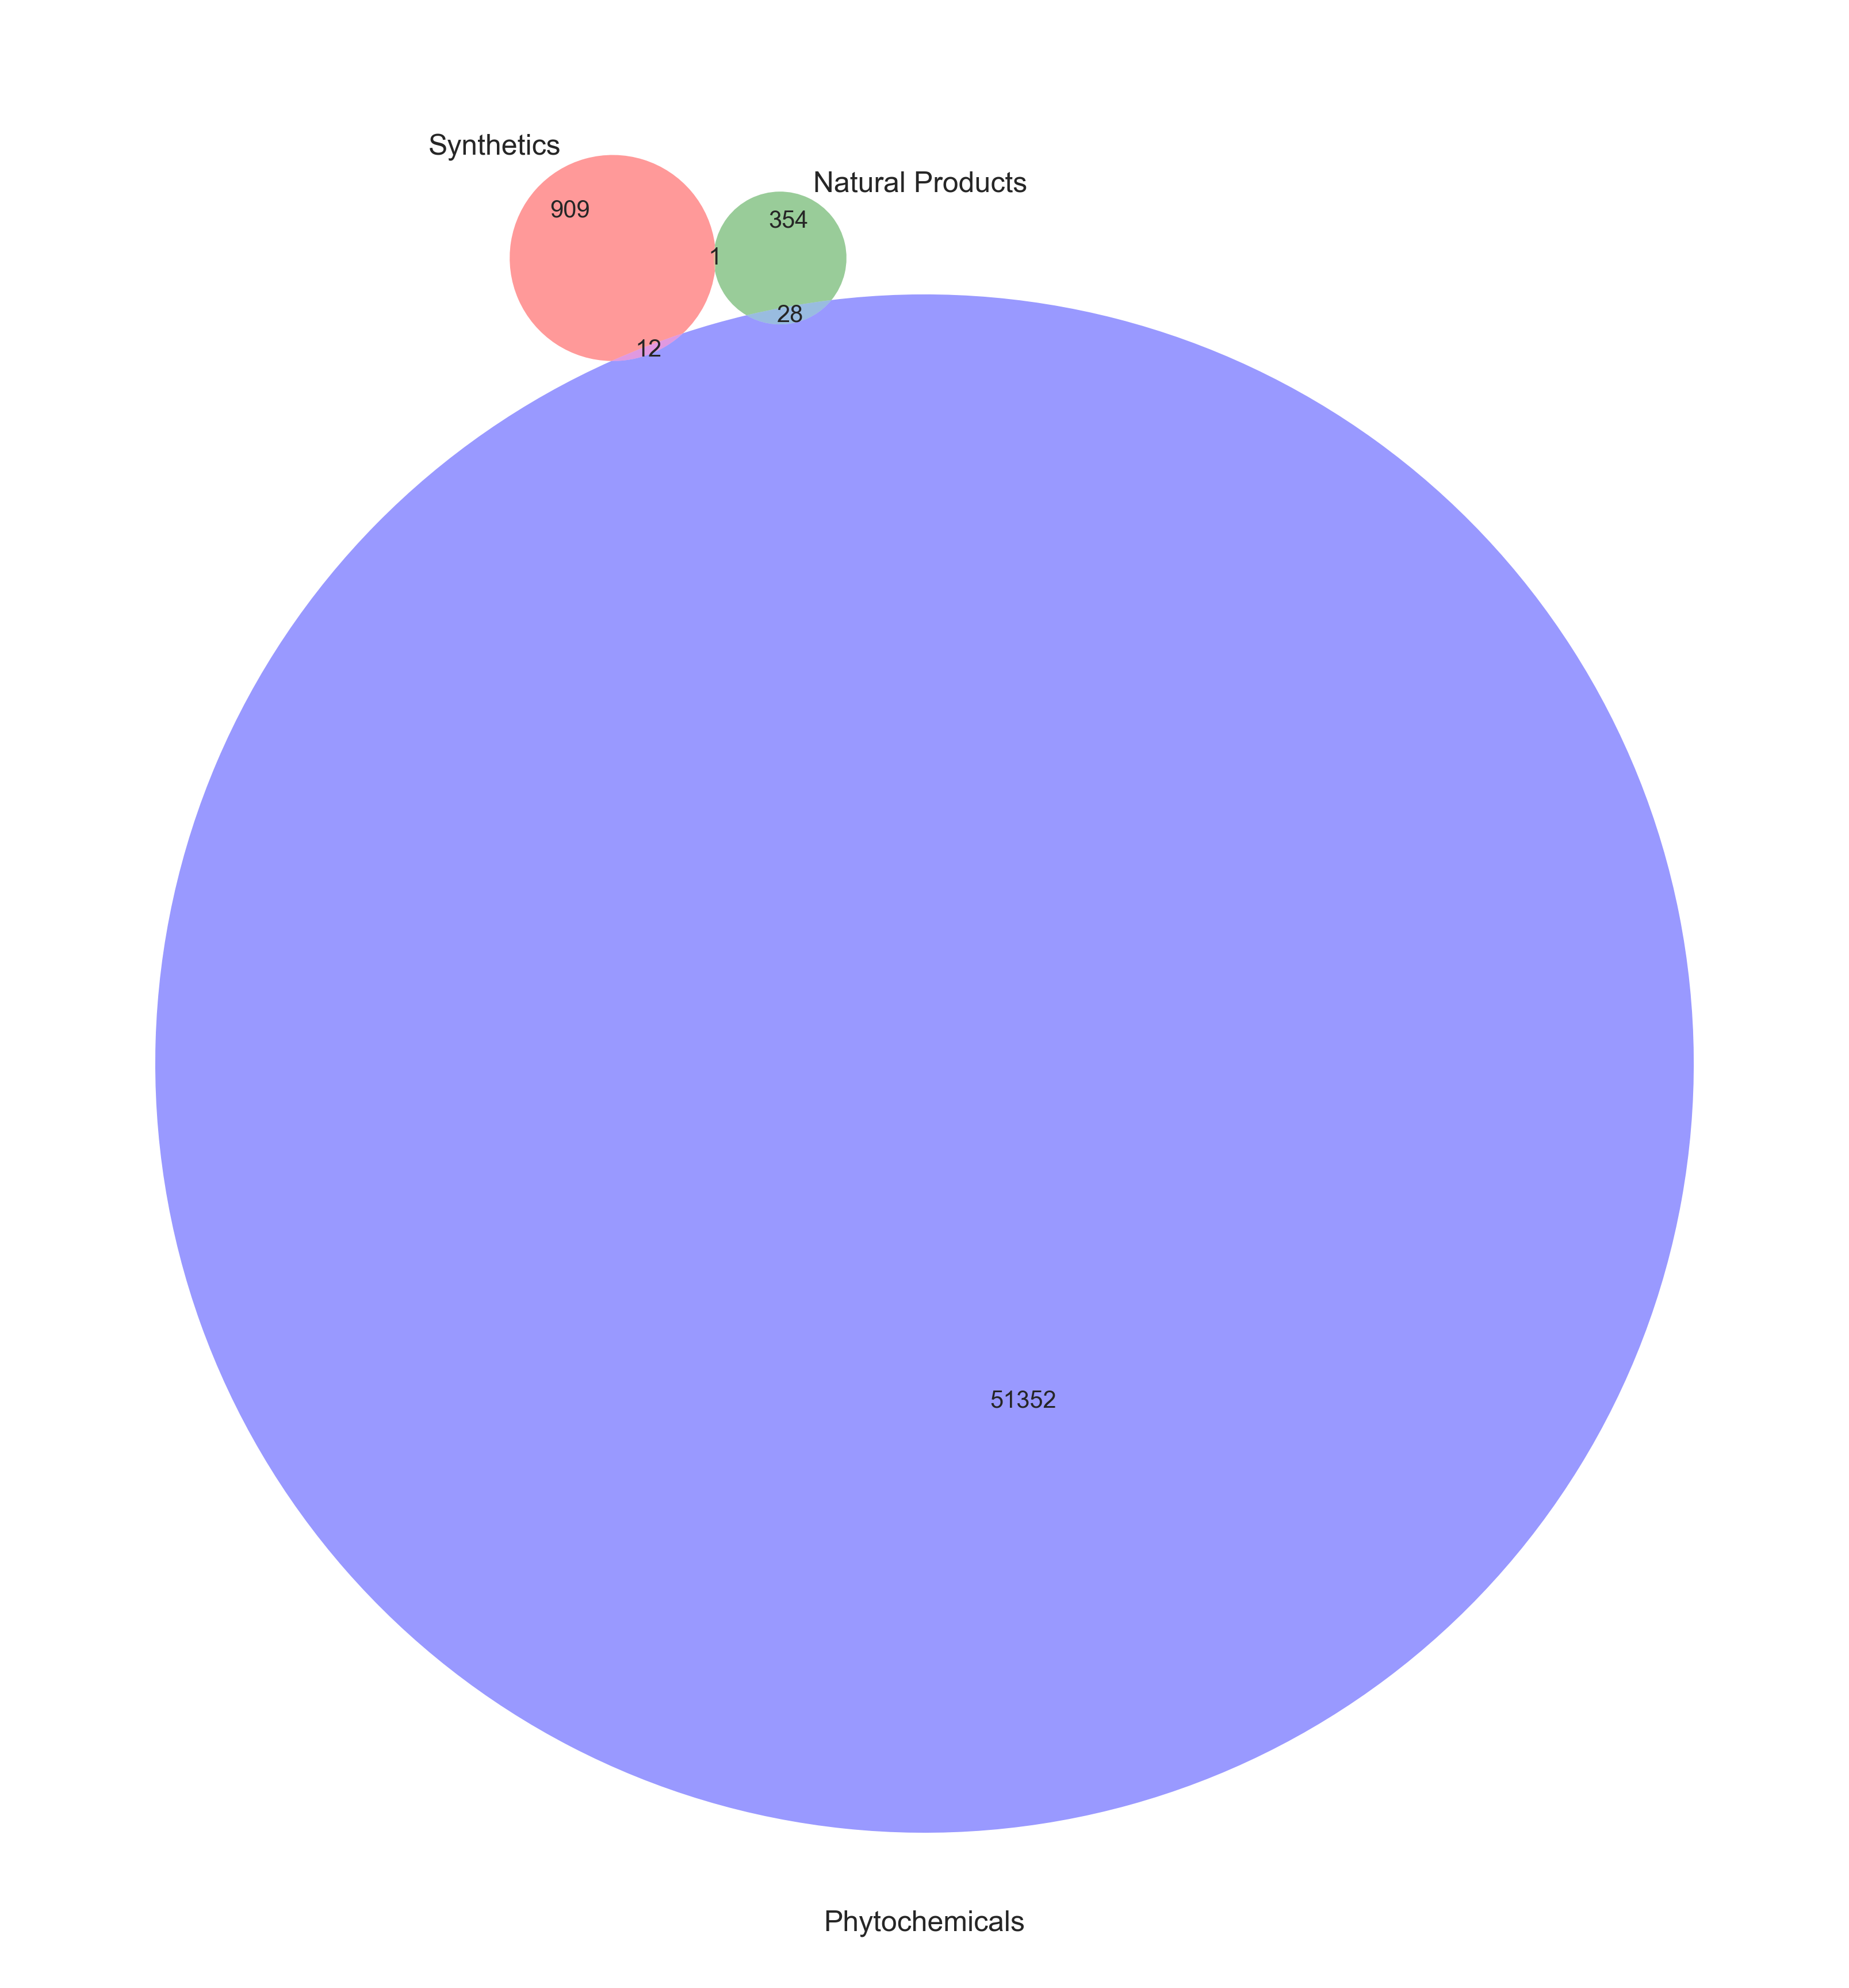

In [34]:
plt.figure(dpi=300, figsize=([15,15]))
venn3([synthethics_inchikeys, natural_products_inchikeys, phytochemicals_inchikey], set_labels = ('Synthetics', 'Natural Products', 'Phytochemicals'))
plt.show()

### Murcko scaffolds

In [25]:
def get_murcko_scaffolds(smiles, skipped):
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped += 1

    return Chem.MolToSmiles(GetScaffoldForMol(molecule))

synthethics_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in synthetics_df.smiles.values
}

natural_products_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in natural_products_df.smiles.values
}

skipped = 0

phytochemicals_murcko ={
    get_murcko_scaffolds(smiles, skipped)
    for smiles in smiles_to_pubchem.keys()
}

In [26]:
skipped

0

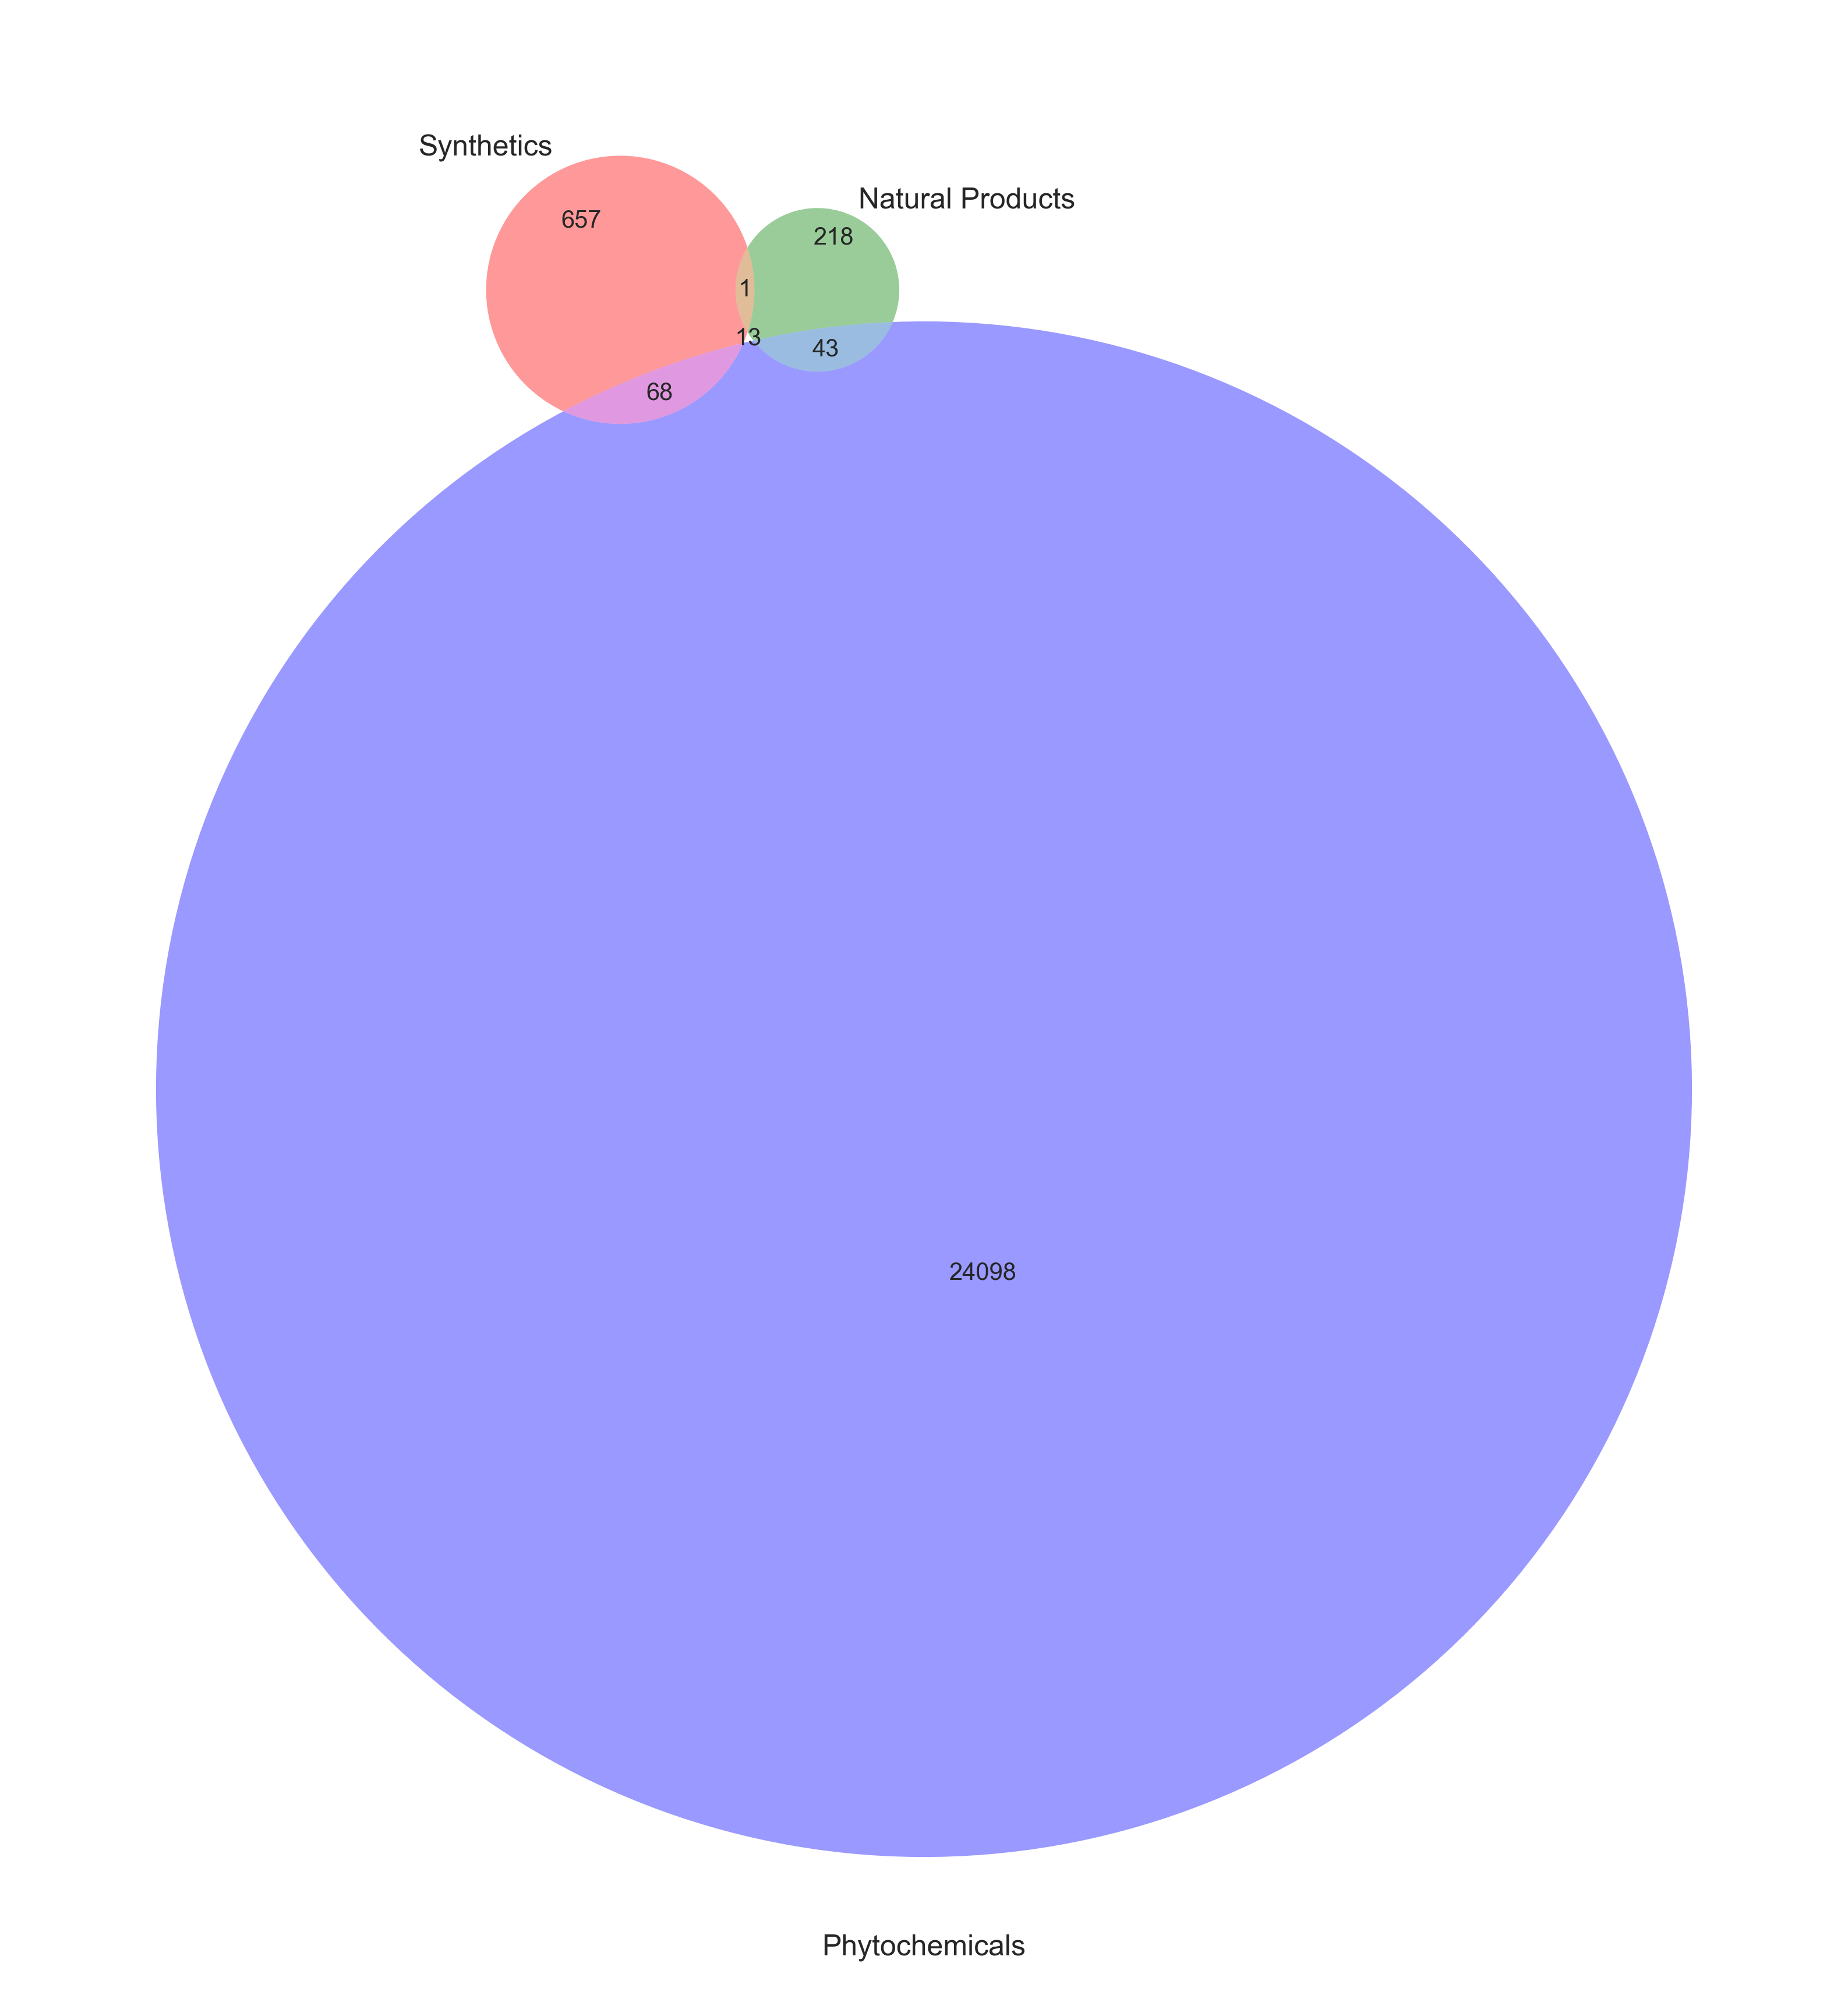

In [32]:
plt.figure(dpi=300, figsize=([15,15]))
venn3([synthethics_murcko, natural_products_murcko, phytochemicals_murcko], set_labels = ('Synthetics', 'Natural Products', 'Phytochemicals'))
plt.show()

Scaffolds in all the three sets

In [36]:
synthethics_murcko.intersection(natural_products_murcko).intersection(phytochemicals_murcko)

{'',
 'C1CCCC1',
 'C1CCCCC1',
 'C1CCOCC1',
 'C1CO1',
 'O=c1ccn([C@H]2CCCO2)c(=O)[nH]1',
 'O=c1ncccn1[C@H]1CCCO1',
 'c1c[nH]cn1',
 'c1ccc2ccccc2c1',
 'c1ccccc1',
 'c1ccncc1',
 'c1ncc2nc[nH]c2n1',
 'c1ncc2ncn([C@H]3CCCO3)c2n1'}